# Spark NLP Application
## Working version for AWS EC2 cluster deployment

In [1]:
sc

<SparkContext master=spark://ec2-54-219-152-127.us-west-1.compute.amazonaws.com:7077 appName=PySparkShell>

In [14]:
sc.stop()

In [73]:
# General
import json
import re, string
import numpy as np
import pandas as pd
import emot
from collections import Counter

# Visual
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

# AWS
import boto3

# Data preprocessing
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, FloatType, ArrayType

# Machine Learning
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
nltk.downloader.download('wordnet')
nltk.downloader.download('vader_lexicon')

In [3]:
pd.__version__

'0.23.0'

In [4]:
sqlContext = SQLContext(sc)
s3 = boto3.resource('s3')
bucket = s3.Bucket('master-thesis-data-st61135')
#aws_secret_access_key = ''
#aws_access_key_id = ''
#sc._jsc.hadoopConfiguration().set("fs.s3a.awsAccessKeyId", aws_access_key_id)
#sc._jsc.hadoopConfiguration().set("fs.s3a.awsSecretAccessKey", aws_secret_access_key)
object_list = [k for k in bucket.objects.all() ]
key_list = [k.key for k in bucket.objects.all()]
key_list

['Books_5.json', 'MetadataBooks.json']

In [5]:
paths = ['s3a://'+o.bucket_name+'/'+ o.key for o in object_list]
path_reviews = paths[0]
data = sqlContext.read.json(path_reviews)
data.createOrReplaceTempView("data")

In [6]:
path_metadata = paths[1]
metadata = spark.read.json(path_metadata)
metadata.createOrReplaceTempView("metadata")

In [ ]:
n = data.count()
n_distinct = data.distinct().count()
users = data.select([c for c in data.columns if c == 'reviewerID']).distinct().count()
books = data.select([c for c in data.columns if c == 'asin']).distinct().count()

print('Liczba obserwacji: {0}'.format(n))
print('Liczba unikatowych obserwacji: {0}'.format(n_distinct))
print('Liczba duplikatów: {0}'.format(n - n_distinct))
print('Liczba użytkowników: {0}'.format(users))
print('Liczba książek: {0}'.format(books))

In [ ]:
sample_data = sample_data.dropDuplicates(subset = [c for c in sample_data.columns if c not in ['asin', 'reviewerID']])
sample_data.createOrReplaceTempView("sample_data")

## Data Cleaning and Extraction

In [7]:
def emoji(string):
    start = ' '.join([i for i in string.split(' ') if not any(a in i for a in ['oo', 'OO', 'xp'])])
    first = emot.emoticons(start)
    second = set([i['value'] for i in first if i and i != ')'])
    return list(second)

emoji_detector = udf(emoji)
data = data.withColumn('Emoji', emoji_detector(col('reviewText')))
data.createOrReplaceTempView("data")

In [8]:
# Łączenie podsumowania komentarza z samym komentarzem
sqlTransform = SQLTransformer(statement="SELECT *, concat(summary, ' ', reviewText) as text, concat(asin, ' ', reviewerID) as ID FROM __THIS__")

# Tokenizacja połączonego tekstu
tokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="[^\\p{L}]")

# Usuwanie zbędnych słów za pomocą stop listy
stopremover = StopWordsRemover(inputCol="tokens", outputCol="stop_tokens")

# Przekształcenie komentarzy w formę wektorową (częstości występowania w całym zbiorze)
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='rawFeatures')

# Obliczenie odwróconej częstotliwości dokumentu
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Definiowanie ciągu operacji na badanym zbiorze
data_preproc = Pipeline(stages=[sqlTransform, tokenizer, stopremover, count_vec, idf])

# Zastosowanie powyższych transformacji
cleaner = data_preproc.fit(data)
data = cleaner.transform(data)
data.createOrReplaceTempView("data")

In [9]:
analyzer = SentimentIntensityAnalyzer()

def sent(scoring):
    if scoring['compound'] > 0.5:
        a = 'positive'
    elif scoring['compound'] < 0.5 and scoring['compound'] > -0.5:
        a = 'neutral'
    else:
        a = 'negative'
    return a

def lemma(x):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(t) for t in x]

sentiment = udf(lambda x: sent(analyzer.polarity_scores(x)), StringType())
votes = udf(lambda h: None if h[1] == 0 else h[1], IntegerType())
helpful = udf(lambda h: h[0], IntegerType())
lemmatize = udf(lemma, ArrayType(StringType(), True))
score = udf(lambda x: analyzer.polarity_scores(x)['compound'], FloatType())

data = data.withColumn('ReviewDate', to_date(from_unixtime(col("unixReviewTime"), format='yyyy-MM-dd'))) \
                     .withColumn('HelpfulVotes', helpful(col("helpful"))) \
                     .withColumn('TotalVotes', votes(col("helpful"))) \
                     .withColumn('RawReviewLength', length(col("reviewText"))) \
                     .withColumn('TokensLength', size(col("tokens"))) \
                     .withColumn('StopTokensLength', size(col("stop_tokens"))) \
                     .withColumn('Lemmatized', lemmatize(col("stop_tokens"))) \
                     .withColumn('Sentiment', sentiment(col("reviewText"))) \
                     .withColumn('Compound_Score', score(col("reviewText"))) \
                     .select('ID', 'asin', 'reviewerID', 'ReviewDate', 'TotalVotes', 'HelpfulVotes', 'overall', 'TokensLength', 'StopTokensLength',
                             'RawReviewLength', 'text', 'stop_tokens', 'Lemmatized', 'Sentiment', 'Compound_Score', 'features')

data.createOrReplaceTempView("data")
#data.cache()

## Data consolidation and outliers removal

In [ ]:
data.agg(*[(1 - (count(c) / count('*'))).alias(c) for c in data.columns]).show()

In [10]:
data = data.dropna() \
           .withColumn('Helpfulness', col("HelpfulVotes")/col('TotalVotes'))
data = data.filter(data.Helpfulness <= 1)
data.createOrReplaceTempView("data")

metadata = spark.sql("""select asin, title, price, salesRank['Books'] as SalesRank
                            from metadata
                            where asin is not null and price is not null
                                  and salesRank['Books'] is not null""")
metadata.createOrReplaceTempView("working_meta")

data_set = spark.sql("""select * from data a
                        left join metadata b
                        on a.asin = b.asin
                        where b.asin is not null""")
data_set.createOrReplaceTempView("data_set")

In [11]:
numerical_columns = ['TotalVotes', 'HelpfulVotes', 'overall', 'TokensLength', 'StopTokensLength',
                    'RawReviewLength', 'Compound_Score', 'Helpfulness', 'price', 'SalesRank', 'Sentiment']
pdData = data_set.select(numerical_columns).toPandas()

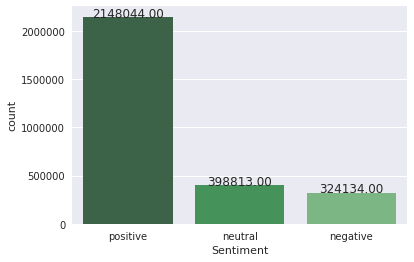

In [12]:
plt.clf()
sns.set(style="darkgrid")
hist = sns.countplot(x="Sentiment", data=pdData, palette="Greens_d")
total = float(len(pdData))
for p in hist.patches:
    height = p.get_height()
    hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center") 
#display(hist.figure)
plt.show()

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


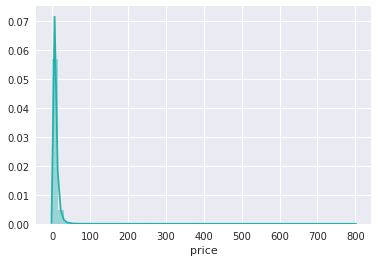

In [13]:
plt.clf()
sns.distplot(pdData.price, color = 'lightseagreen')
plt.show()

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

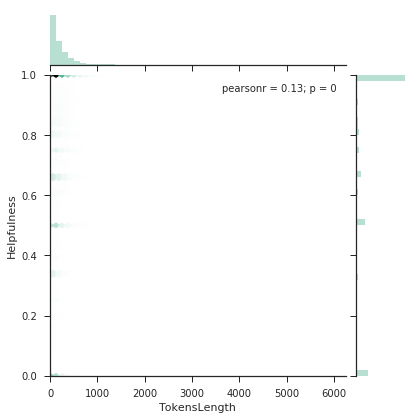

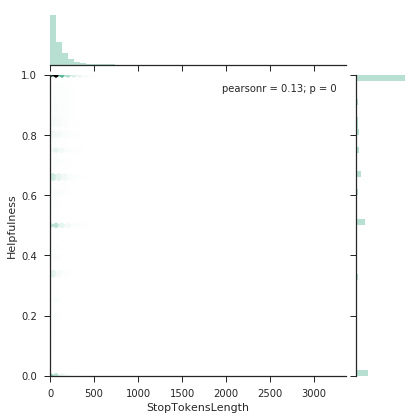

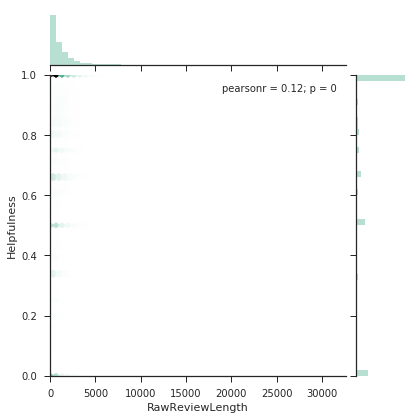

In [15]:
plt.clf()
sns.set(style="ticks")
len_cols =  [i for i in pdData.columns if 'Length' in i]
d = {}
for c in len_cols:
    g = sns.jointplot(x=pdData[c], y=pdData["Helpfulness"], kind='hex', color="#4CB391")
    d[c] = g.fig

d[len_cols[2]]
plt.show()

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

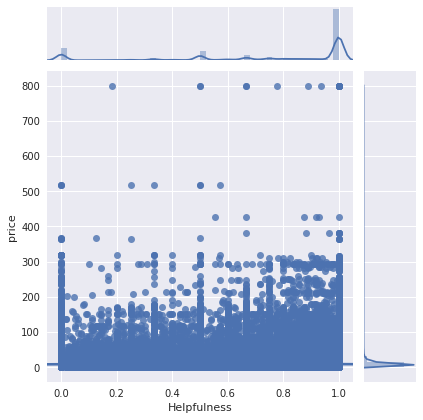

In [14]:
plt.clf()
g = sns.JointGrid(x="Helpfulness", y="price", data=pdData) 
g.plot_joint(sns.regplot, order=2)
g.plot_marginals(sns.distplot)
plt.show()

<Figure size 432x288 with 0 Axes>

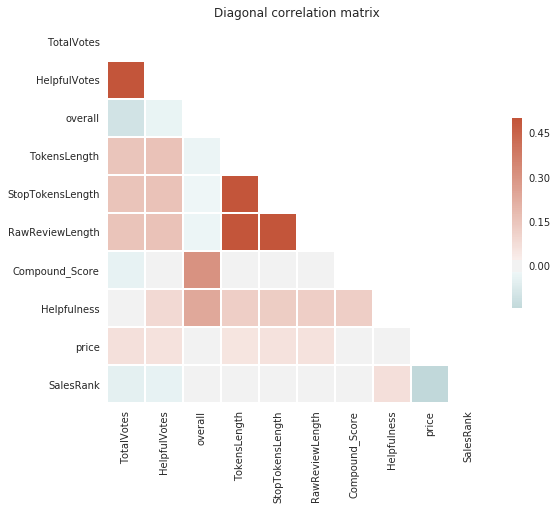

In [16]:
plt.clf()

sns.set(style="white")

corr = pdData[num_cols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(9, 7))

cmap = sns.diverging_palette(200, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.65, cbar_kws={"shrink": .5})
ax.set_title('Diagonal correlation matrix')
plt.show()

<Figure size 432x288 with 0 Axes>

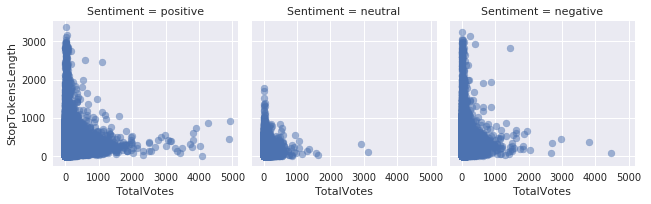

<Figure size 1080x648 with 0 Axes>

In [53]:
plt.clf()
g = sns.FacetGrid(pdData, col="Sentiment")
g.map(plt.scatter, "TotalVotes", "StopTokensLength", alpha=.5)
g.add_legend()
plt.figure(figsize=(15,9))
plt.show()

In [55]:
pdData.columns

Index(['TotalVotes', 'HelpfulVotes', 'overall', 'TokensLength',
       'StopTokensLength', 'RawReviewLength', 'Compound_Score', 'Helpfulness',
       'price', 'SalesRank', 'Sentiment'],
      dtype='object')

In [66]:
metrics_by_sentiment = pdData.groupby('Sentiment').agg({"price": "max", "overall": "mean"})
metrics_by_sentiment.columns = ['Average Score', 'Maximum Price']
metrics_by_sentiment

,Average Score,Maximum Price
Sentiment,,
negative,3.346560,518.31
neutral,3.596681,518.31
positive,4.302157,799.97


# Outliers

In [18]:
data_set.persist()

DataFrame[ID: string, asin: string, reviewerID: string, ReviewDate: date, TotalVotes: int, HelpfulVotes: int, overall: double, TokensLength: int, StopTokensLength: int, RawReviewLength: int, text: string, stop_tokens: array<string>, Lemmatized: array<string>, Sentiment: string, Compound_Score: float, features: vector, Helpfulness: double, asin: string, title: string, price: double, SalesRank: bigint]

In [19]:
cols = ['price', 'RawReviewLength']
bounds = {}

for col in cols:
    quantiles = data_set.approxQuantile(col, [0.25, 0.75], 0)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [
        quantiles[0] - 1.5 * IQR, 
        quantiles[1] + 1.5 * IQR
]

In [20]:
bounds

{'RawReviewLength': [-1407.0, 3121.0], 'price': [-3.179999999999999, 18.5]}

In [21]:
outliers = data_set.select(*['ID'] + [
    (
        (data_set[c] > 0) & (data_set[c] < bounds[c][1])
    ).alias(c + '_out') for c in cols
])
#outliers.show()

In [22]:
df_outliers = data_set.join(outliers, on='ID')
df_out = df_outliers.filter('price_out').filter('RawReviewLength_out').filter(df_outliers.TotalVotes < 200) \
                         .drop('price_out').drop('RawReviewLength_out')
#display(df_out)

In [23]:
pdData_out = df_out.select(num_cols).toPandas()

<Figure size 432x288 with 0 Axes>

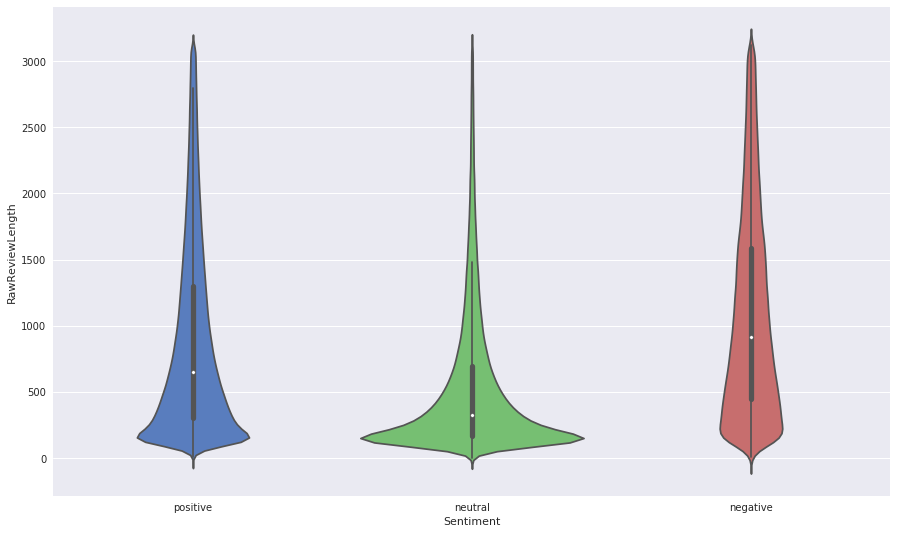

In [52]:
plt.clf()
plt.figure(figsize=(15,9))
#violin = 
sns.violinplot(x="Sentiment", y="RawReviewLength", data=pdData_out, palette="muted")
#display(violin.figure)
plt.show()

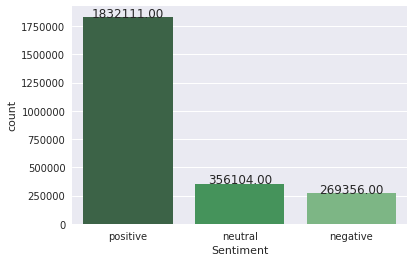

<Figure size 936x720 with 0 Axes>

In [50]:
plt.clf()
sns.set(style="darkgrid")
hist = sns.countplot(x="Sentiment", data=pdData_out, palette="Greens_d")
total = float(len(pdData_out))
for p in hist.patches:
    height = p.get_height()
    hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center") 
#display(hist.figure)
plt.figure(figsize=(13,10))
plt.show()

In [29]:
pdData_out.columns

Index(['TotalVotes', 'HelpfulVotes', 'overall', 'TokensLength',
       'StopTokensLength', 'RawReviewLength', 'Compound_Score', 'Helpfulness',
       'price', 'SalesRank', 'Sentiment'],
      dtype='object')

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

<Figure size 936x720 with 0 Axes>

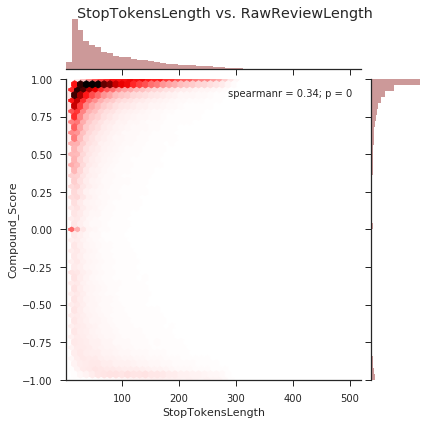

In [49]:
from scipy.stats import spearmanr

plt.clf()
plt.figure(figsize=(13,10))
sns.set(style="ticks")
g = sns.jointplot(x=pdData_out['StopTokensLength'], y=pdData_out["Compound_Score"], kind='hex', color="maroon", stat_func=spearmanr)
g.fig.suptitle('StopTokensLength vs. RawReviewLength')
#display(g.fig)
plt.show()

In [ ]:
def most_common_words(set, column, n = 100):
    data_pd = set.select(column).toPandas()
    reviews = data_pd[column].tolist()
    out = []
    for i in range(0, len(reviews)):
        out.extend([e.encode('utf-8').strip() for e in reviews[i] if len(e.encode('utf-8').strip()) > 2])
    out = Counter(out).most_common(n)
    toPD = pd.DataFrame(out, columns = ['Words', ' Count']).set_index('Words')
    d = {}
    for i in range(0, n):
        d[list(toPD.index)[i]] = toPD.iloc[:,0][i]
    return d

def show_wordcloud(set, backgroud = "white"):
    wc = WordCloud(background_color = backgroud, max_words=2000,
               max_font_size=40, random_state=42)
    wc.generate_from_frequencies(set)
    wcd = plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    display(wcd)

top_100 = most_common_words(data_set, 'Lemmatized')
show_wordcloud(top_100)

In [27]:
pdData_out.head()

,TotalVotes,HelpfulVotes,overall,TokensLength,StopTokensLength,RawReviewLength,Compound_Score,Helpfulness,price,SalesRank,Sentiment
0,1,0,5.0,90,51,502,0.9084,0.00,8.52,2296729,positive
1,1,1,5.0,59,31,252,0.6931,1.00,8.52,2296729,positive
2,1,1,5.0,26,15,114,0.6908,1.00,8.52,2296729,positive
3,1,1,5.0,21,12,97,0.6997,1.00,8.52,2296729,positive
4,8,6,5.0,99,40,451,0.8798,0.75,8.52,2296729,positive


# Model

In [35]:
df_out = df_out.select('ID', 'title', 'price', 'SalesRank', 'ReviewDate', 'overall', 'Lemmatized', 'TotalVotes', 'HelpfulVotes',
                           'Helpfulness', 'RawReviewLength', 'StopTokensLength', 'features', 'Compound_Score', 'Sentiment') \
                   .filter(data_set.Sentiment != 'neutral')

df_out.createOrReplaceTempView("df_out")

indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
fitted_data = indexer.fit(df_out)
indexed_data = fitted_data.transform(df_out)#.cache()
#display(indexed_data.select('Sentiment', 'label'))

In [38]:
indexed_data.select('Sentiment', 'label').show(n = 10, truncate=False)

+---------+-----+
|Sentiment|label|
+---------+-----+
|positive |0.0  |
|positive |0.0  |
|positive |0.0  |
|positive |0.0  |
|positive |0.0  |
|positive |0.0  |
|positive |0.0  |
|positive |0.0  |
|negative |1.0  |
|positive |0.0  |
+---------+-----+
only showing top 10 rows



In [40]:
stratified_data = indexed_data.sampleBy('label', fractions={0: 269356./1832111, 1: 1.0})
stratified_data.groupby('label').count().show()#.toPandas()

+-----+------+
|label| count|
+-----+------+
|  0.0|269292|
|  1.0|269356|
+-----+------+



In [ ]:
stratified_data.show(n = 10, truncate=False)

In [42]:
splits = stratified_data.select(['label', 'features']).randomSplit([0.8,0.2],seed=123)
train = splits[0].cache()
test = splits[1].cache()

In [ ]:
to_float = udf(lambda x: x['label'], FloatType())
label = stratified_data.rdd.map(lambda x: to_float(x))
features = stratified_data.rdd.map(lambda x: (x['features'], ))
scaler = StandardScaler().fit(features).transform(features)#.toDF(['features'])
data1 = label.zip(scaler).toDF(['label', 'features'])
data1.show()

In [43]:
nb = NaiveBayes(smoothing=3.0, modelType="multinomial")

# Trenowanie modelu
model = nb.fit(train)

# Sprawdzenie modelu na zbiorze testowym
predictions = model.transform(test)

# Obliczenie jakości modelu
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
predictions.show()

Test set accuracy = 0.7977833426080505
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(262144,[0,1,2,3,...|[-7651.9375426715...|[1.0,1.1059204521...|       0.0|
|  0.0|(262144,[0,1,2,3,...|[-7395.0009918105...|[1.0,1.7572466229...|       0.0|
|  0.0|(262144,[0,1,2,3,...|[-8331.7366185110...|[1.0,3.0381429538...|       0.0|
|  0.0|(262144,[0,1,2,3,...|[-7305.0381655442...|[1.0,1.5496907576...|       0.0|
|  0.0|(262144,[0,1,2,3,...|[-1245.8230476271...|[1.0,5.4822371187...|       0.0|
|  0.0|(262144,[0,1,2,3,...|[-10626.911173058...|[1.70991530814941...|       1.0|
|  0.0|(262144,[0,1,2,3,...|[-4130.1773830308...|[1.0,2.9946201113...|       0.0|
|  0.0|(262144,[0,1,2,3,...|[-3378.8156340929...|[1.0,3.6846916845...|       0.0|
|  0.0|(262144,[0,1,2,3,...|[-7091.7127966407...|[1.7744032

In [ ]:
# Create (prediction, label) pairs
predictionAndLabel = predictions.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print(metrics.confusionMatrix())
confMatrx = metrics.confusionMatrix().toArray().astype(int)

<Figure size 432x288 with 0 Axes>

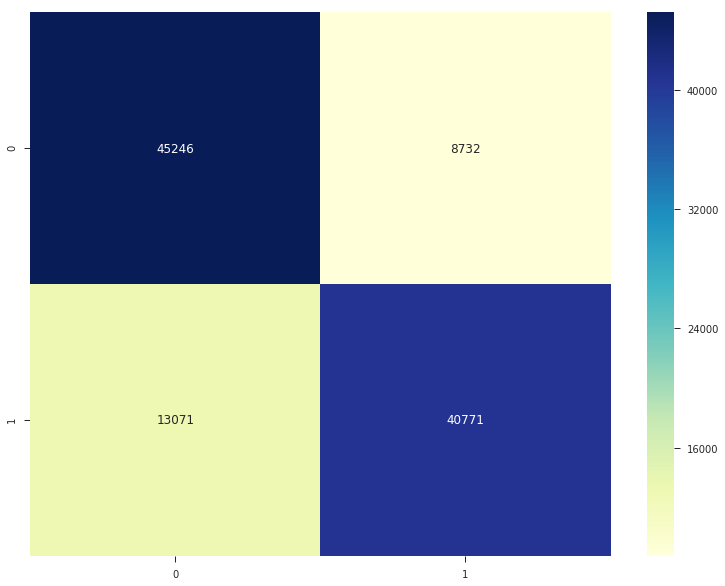

In [47]:
plt.clf()
plt.figure(figsize=(13,10))
sns.heatmap(confMatrx, annot=True, fmt="d", cmap="YlGnBu")
#display(ax.figure)
plt.show()

In [67]:
smoothing = np.arange(0.0, 1.0, 0.1).tolist()

paramGrid = ParamGridBuilder().addGrid(nb.smoothing, smoothing).build()
cvEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)
cvModel = cv.fit(train)

cvPredictions = cvModel.transform(test)
cvPredictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[1.0,5.1039750296...|
|  0.0|       0.0|[1.0,2.6768493371...|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|[1.0,2.6403598535...|
|  0.0|       0.0|[1.0,3.7980416011...|
|  0.0|       1.0|[2.97237838935693...|
|  0.0|       0.0|[1.0,1.1962872437...|
|  0.0|       0.0|           [NaN,NaN]|
|  0.0|       0.0|           [NaN,NaN]|
|  0.0|       0.0|[1.0,1.4536870389...|
|  0.0|       0.0|[1.0,1.2273333935...|
|  0.0|       1.0|           [0.0,1.0]|
|  0.0|       0.0|[0.99999999999997...|
|  0.0|       0.0|[0.99999999999999...|
|  0.0|       1.0|[4.53237974067426...|
|  0.0|       0.0|           [NaN,NaN]|
|  0.0|       0.0|[1.0,5.4141003094...|
|  0.0|       0.0|[0.99999999999999...|
|  0.0|       0.0|[0.99999999999998...|
|  0.0|       0.0|           [1.0,0.0]|
+-----+----------+--------------------+
only showing top 20 rows



In [71]:
print("Test set accuracy = " + str(cvEvaluator.evaluate(cvPredictions)))

Test set accuracy = 0.7420330179929512


In [68]:
cvPredictions_val = cvPredictions.select("prediction", "label").rdd

metrics_cv = MulticlassMetrics(cvPredictions_val)
print(metrics_cv.confusionMatrix())
confMatrx_cv = metrics_cv.confusionMatrix().toArray().astype(int)

DenseMatrix([[45070.,  8908.],
             [18906., 34936.]])


<Figure size 432x288 with 0 Axes>

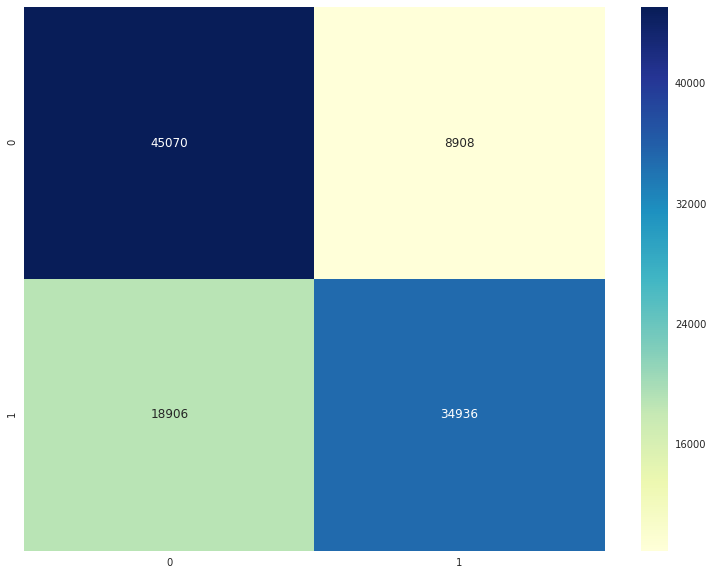

In [69]:
plt.clf()
plt.figure(figsize=(13,10))
sns.heatmap(confMatrx_cv, annot=True, fmt="d", cmap="YlGnBu")
#display(ax.figure)
plt.show()

# N-Grams

### Add ngram column

In [81]:
n = 2
ngram = NGram(inputCol = 'Lemmatized', outputCol = 'ngram', n = n)
add_ngram = ngram.transform(stratified_data)

### Count vectorizer and tfidf

In [82]:
cv_ngram = CountVectorizer(inputCol='ngram', outputCol='tf_ngram')
cvModel_ngram = cv_ngram.fit(add_ngram)
cv_df_ngram = cvModel_ngram.transform(add_ngram)

### Create TF-IDF matrix

In [83]:
idf_ngram = IDF().setInputCol('tf_ngram').setOutputCol('tfidf_ngram')
tfidfModel_ngram = idf_ngram.fit(cv_df_ngram)
tfidf_df_ngram = tfidfModel_ngram.transform(cv_df_ngram)

### Split into training & testing set

In [84]:
splits_ngram = tfidf_df_ngram.select(['tfidf_ngram', 'label']).randomSplit([0.8,0.2],seed=123)
train_ngram = splits_ngram[0].cache()
test_ngram = splits_ngram[1].cache()

### Convert feature matrix to LabeledPoint vectors

In [85]:
train_lb_ngram = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))
test_lb_ngram = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))

### Fit SVM model of only trigrams

In [89]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import  Vectors as MLLibVectors

numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb_ngram, numIterations, regParam=regParam)

### Extract top 20 trigrams based on weights

In [103]:
scoreAndLabels_test = test_lb_ngram.map(lambda x: (float(svm.predict(x.features)), x.label))
score_label_test = spark.createDataFrame(scoreAndLabels_test, ["prediction", "label"])
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
svm_f1 = f1_eval.evaluate(score_label_test)
print("F1 score: %.4f" % svm_f1)

F1 score: 0.7962


In [95]:
add_ngram.select('ngram').show()

+--------------------+
|               ngram|
+--------------------+
|[water camel, cam...|
|[innovative story...|
|[lot fun, fun mac...|
|[military porn, p...|
|[good book, book ...|
|[pleasant christi...|
|[evengollum much,...|
|[people see, see ...|
|[creative story, ...|
|[difficult read, ...|
|[authorsden revie...|
|[deeply disappoin...|
|[love odd, odd th...|
|[deeply odd, odd ...|
|[forget evening, ...|
|[riveting read, r...|
|[incredible survi...|
|[author thinking,...|
|[disappointing po...|
|[surely one, one ...|
+--------------------+
only showing top 20 rows



# LDA

In [78]:
# https://dzone.com/articles/spark-lda-a-complete-example-of-clustering-algorit
# https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3741049972324885/3783546674231782/4413065072037724/latest.html
# https://spark.apache.org/docs/2.1.0/mllib-clustering.html
# http://www.cs.pomona.edu/~achambers/papers/thesis_final.pdf


from pyspark.ml.clustering import LDA
lda = LDA(k=10, maxIter=10)
model = lda.fit(train)

ll = model.logLikelihood(train)
lp = model.logPerplexity(train)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

# Describe topics.
topics = model.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

# Shows the result
transformed = model.transform(test)
transformed.show(truncate=False)

The lower bound on the log likelihood of the entire corpus: -1669431146.874486
The upper bound on perplexity: 9.462631057665678
The topics described by their top-weighted terms:
+-----+----------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                         |termWeights                                                                                                                                                                                                                          |
+-----+----------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [107]:
count_vec = CountVectorizer(inputCol='Lemmatized',outputCol='rawFeatures')
count_vec_model = count_vec.fit(stratified_data)

vocab = count_vec_model.vocabulary

In [112]:
transformed.show()

+-----+--------------------+--------------------+
|label|            features|   topicDistribution|
+-----+--------------------+--------------------+
|  0.0|(262144,[0,1,2,3,...|[0.48549654741232...|
|  0.0|(262144,[0,1,2,3,...|[0.99903298786691...|
|  0.0|(262144,[0,1,2,3,...|[0.81133990843998...|
|  0.0|(262144,[0,1,2,3,...|[0.71889266516389...|
|  0.0|(262144,[0,1,2,3,...|[0.99470679496663...|
|  0.0|(262144,[0,1,2,3,...|[0.54559018926711...|
|  0.0|(262144,[0,1,2,3,...|[0.99823857911466...|
|  0.0|(262144,[0,1,2,3,...|[0.81295209577790...|
|  0.0|(262144,[0,1,2,3,...|[0.65711836695531...|
|  0.0|(262144,[0,1,2,3,...|[0.19846579744667...|
|  0.0|(262144,[0,1,2,3,...|[0.99814513343000...|
|  0.0|(262144,[0,1,2,3,...|[0.30466179082749...|
|  0.0|(262144,[0,1,2,3,...|[0.37203339952966...|
|  0.0|(262144,[0,1,2,3,...|[0.69272787162045...|
|  0.0|(262144,[0,1,2,3,...|[0.63805818075601...|
|  0.0|(262144,[0,1,2,3,...|[0.14961476221963...|
|  0.0|(262144,[0,1,2,3,...|[0.26216916705496...|


In [113]:
topics_words = topics.rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):
    print("topic: ", idx)
    print("----------")
    for word in topic:
        print(word)
    print("----------")

topic:  0
----------
story
one
well
character
book
think
author
read
first
really
----------
topic:  1
----------
book
one
story
read
much
get
character
really
time
well
----------
topic:  2
----------
terrible
around
find
one
people
pain
family
genre
book
hired
----------
topic:  3
----------
case
help
local
quality
told
judge
find
sarah
cross
owner
----------
topic:  4
----------
around
one
armor
case
book
series
get
everywhere
skilled
story
----------
topic:  5
----------
interested
book
one
whether
character
let
many
also
new
make
----------
topic:  6
----------
even
book
character
one
really
story
operation
novel
risk
great
----------
topic:  7
----------
around
book
one
like
character
get
love
read
author
also
----------
topic:  8
----------
start
poor
note
also
people
first
family
book
early
enjoyable
----------
topic:  9
----------
curious
stock
wounded
computer
find
people
one
deal
officer
family
----------


In [ ]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[0], Vectors.dense(row[1])))

model = DecisionTree.trainClassifier(labelData(train), numClasses=2, maxDepth=5,
                                     categoricalFeaturesInfo={},
                                     impurity='gini', maxBins=32)

print(model.toDebugString())

# Manual tokenazation example

In [ ]:
sent = "I plan to buy 3 more copies from Amazon, for my departing son & distant friends.Last night, I made a mad dash to get a copy of this book, ten minutes before the book store closed; because I couldn't find my old one.  I had been trying unsuccessfully for weeks to send out an SOS to a life-long friend whose comforting presence I really needed, even if just by phone.  Long, sun-lit walks through my beautiful neighborhood lined with 100+ year old oaks, magnolias, elms, and maple trees, did not make me feel any better.  At home, the news is only reporting the political and ecomonic turmoil going on world-wide, or the Oscars; the latter which I could care less about.  It was a very sad and loney moment.Back in Miami I would naturally hit the beach, or watch the ocean from my balcony and forget the world.  So, in desperation, I jumped in my vehicle, hit the book store, and called on the wisdom of Mr. Gibran.  I sipped a glass of red, kicked back on my couch, and slowly read aloud each blessed passage on all the areas of life and the challenges they can present.  I don't know why, but this book always makes me cry at the beginning and smile at the end.  In little over an hour I'd read slowly through each page, and felt 100% better.On physical inspection, this would be the student slackers paradise book report choice.  But don't be so easily deceived, because this book packs more useful information than any 50-pound college textbook, without the endless verbage of a 1,000 page Russian novel.It is small, the paper of good weight and quality (the ones I always purchase, at least), the print is big and the illustrations done by Mr. Gibran are simple yet humana and divinical.  The words are brief and powerful, comforting and idiot-proof.  Perfect healing food for the love-starved yet attention-deficit crazy world we now live in.  I was first given this book by a friend, as a departing gift for a 7,000 land/sea voyage, back in 1983.I hope to be there for my friend should he ever need me.  I sent this book to him as my comforting presence."

In [ ]:
def clean_review(review):
    punctuation_remover = re.compile('[%s]' % re.escape(string.punctuation))
    review = punctuation_remover.sub(' ', review)
    review = re.sub(r'[^\w][ +]', ' ', re.sub('[^\D]', ' ', review))
    return review

def remove_spaces(review):
    space_rem = [i for i in review.split(" ") if len(i) > 1]
    return ' '.join(space_rem)
  
def output(review):
    return remove_spaces(clean_review(review))

clear = udf(lambda rv: output(rv), StringType())
votes = udf(lambda h: h[0], IntegerType())
helpfulness = udf(lambda h: None if h[0] == 0 else h[0]/h[1], FloatType())

In [ ]:
sample_data = sample_data.withColumn('CleanedReview', split(lower(clear(col("reviewText"))), " ")) \
                     .withColumn('CleanedSummary', split(lower(clear(col("summary"))), " ")) \
                     .withColumn('ReviewDate', to_date(from_unixtime(col("unixReviewTime"), format='yyyy-MM-dd'))) \
                     .withColumn('Helpfulness', helpfulness(col("helpful"))) \
                     .withColumn('Votes', votes(col("helpful"))) \
                     .withColumn('RawReviewLength', length(col("reviewText"))) \
                     .select('asin', 'reviewerID', 'ReviewDate', 'Votes', 'Helpfulness', 'RawReviewLength', 'CleanedSummary', 'CleanedReview')
            
remover_review = StopWordsRemover(inputCol="CleanedReview", outputCol="Rv_words")
remover_summary = StopWordsRemover(inputCol="CleanedSummary", outputCol="Sm_words")
sample_data = remover_review.transform(sample_data)
sample_data = remover_summary.transform(sample_data)

sample_data = sample_data.withColumn('Rv_words_len', size(col("Rv_words"))) \
                         .withColumn('Sm_words_len', size(col("Sm_words"))) \
                         .drop('CleanedSummary', 'CleanedReview')